# Speech Emotion Recognition

This notebook is based on the paper Giuseppe de Pinto et all (GitHub repo : https://github.com/marcogdepinto/emotion-classification-from-audio-files). Their CNN based model was trained on both RAVDESS and TESS and achived a weighted F1 score of 0.91 on the test set. A few changes where made to their implementaion:

* Extracting labels from the TESS dataset 
* Splitting the data into train, test and validation set. 
* Changed the number of epochs from 1000 to 100 and saved the best model checkpoint 
* Created evaluation visualisations <br>

##### To run the notebook please place the TESS data ( i.e. folder OAF_../YAF_..) in the folder "TESS Toronto emotional speech set data"
----------
[1] M. G. de Pinto, M. Polignano, P. Lops and G. Semeraro, "Emotions Understanding Model from Spoken Language using Deep Neural Networks and Mel-Frequency Cepstral Coefficients," 2020 IEEE Conference on Evolving and Adaptive Intelligent Systems (EAIS), 2020, pp. 1-5, doi: 10.1109/EAIS48028.2020.9122698.


In [ ]:
import os
import time
import librosa
import numpy as np
import joblib
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import re
import pandas as pd

# Prepare Data

In [3]:
## extract data and labels

label_list = []
mfccs_list = []

path = "TESS Toronto emotional speech set data"
for subdir, dirs, files in os.walk(path):

            for file in files:
                file_path = os.path.join(subdir, file)
                dir_name = os.path.basename(os.path.dirname(file_path))
                label_list.append(re.sub('pleasant_surprised','pleasant_surprise',dir_name[4:].lower())) # merge classes
                try:
                    
                    X, sample_rate = librosa.load((file_path),
                                        res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate,
                                                         n_mfcc=40).T, axis=0)
                    mfccs_list.append(mfccs)
            
                except ValueError as err:
                    print(err)
                    continue  

# fetch labels
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(label_list)
int_label_list = label_encoder.transform(label_list)
int_label_list
label_encoder.classes_             

X, y = np.asarray(mfccs_list), int_label_list

In [4]:
# check shapes
X.shape,y.shape

((2800, 40), (2800,))

In [5]:
# train test validation split
X_train, X_test_full, y_train, y_test_full = train_test_split(X, y, test_size=0.40, random_state=8)
X_val, X_test, y_val, y_test = train_test_split(X_test_full, y_test_full, test_size=0.5, random_state=8)
x_traincnn = np.expand_dims(X_train, axis=2)
x_valcnn = np.expand_dims(X_val, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)


# Train Model

In [7]:
# model 

model = Sequential()
model.add(Conv1D(64, 5, padding='same',
                    input_shape=(40, 1)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(7))
model.add(Activation('softmax'))

print(model.summary)

model.compile(loss='sparse_categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])
model_name = 'Emotion_Voice_Detection_Model.h5'
checkpoint = ModelCheckpoint(model_name, save_best_only=True, monitor='accuracy', mode='max')

cnn_history = model.fit(x_traincnn, y_train,
                        batch_size=16, epochs=100,
                        validation_data=(x_valcnn, y_val),
                       callbacks = [checkpoint])

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x0000020A5E321E40>>
Epoch 1/100
105/105 [==============================] - 3s 12ms/step - loss: 2.1984 - accuracy: 0.6393 - val_loss: 0.0913 - val_accuracy: 0.9661
Epoch 2/100
105/105 [==============================] - 1s 8ms/step - loss: 0.4107 - accuracy: 0.8935 - val_loss: 0.1343 - val_accuracy: 0.9482
Epoch 3/100
105/105 [==============================] - 1s 9ms/step - loss: 0.2057 - accuracy: 0.9423 - val_loss: 0.0814 - val_accuracy: 0.9732
Epoch 4/100
105/105 [==============================] - 1s 9ms/step - loss: 0.1170 - accuracy: 0.9714 - val_loss: 0.0361 - val_accuracy: 0.9875
Epoch 5/100
105/105 [==============================] - 1s 7ms/step - loss: 0.0963 - accuracy: 0.9679 - val_loss: 0.0830 - val_accuracy: 0.9786
Epoch 6/100
105/105 [==============================] - 1s 8ms/step - loss: 0.0539 - accuracy: 0.9821 - val_loss: 0.1154 - val_accuracy: 0.9607
Epoch 7/100
105/105 [======================

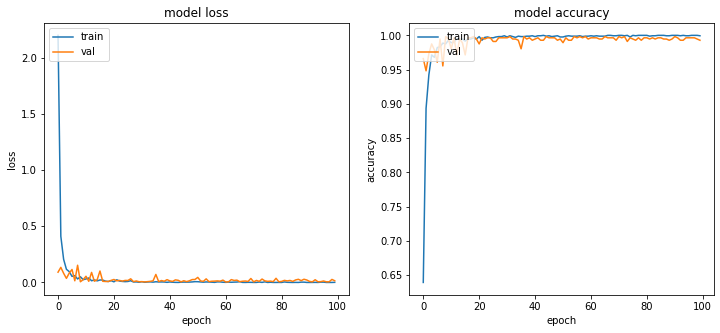

In [10]:
# 
plt.rcParams['figure.figsize'] = (12,5)
fig, axs = plt.subplots(1,2)

axs[0].plot(cnn_history.history['loss'])
axs[0].plot(cnn_history.history['val_loss'])
axs[0].set_title('model loss')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'val'], loc='upper left')


# Accuracy plotting
axs[1].plot(cnn_history.history['accuracy'])
axs[1].plot(cnn_history.history['val_accuracy'])
axs[1].set_title('model accuracy')
axs[1].set_ylabel('accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
predictions = np.argmax(model.predict(x_testcnn),axis =1)
# pred = np.argmax(predictions,axis =1)
new_y_test= y_test
# print("accuracy: ",np.mean(new_y_test == predictions))
matrix = confusion_matrix(new_y_test, predictions)

# print(classification_report(new_y_test, predictions))
# print(matrix)



# # Save model and weights
MODEL_DIR_PATH = "model"
if not os.path.isdir(MODEL_DIR_PATH):
    os.makedirs(MODEL_DIR_PATH)
model_path = os.path.join(MODEL_DIR_PATH, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)
# predictions.shape,pred.shape
print("label array: ",label_encoder.classes_)

18/18 [==============================] - 0s 3ms/step
Saved trained model at model\Emotion_Voice_Detection_Model.h5 
label array:  ['angry' 'disgust' 'fear' 'happy' 'neutral' 'pleasant_surprise' 'sad']


# Evaluation

In [12]:
# Evaluation

# report_pd = pd.DataFrame(matrix).transpose()
# report_pd.rename(columns = {0:'angry', 1:'disgust',2:'fear',3:'happy',4:'neutral',5:'pleasant surprise',6:'sad'}, inplace = True)
# report_pd['label'] = label_encoder.classes_
# report_pd.set_index('label',inplace = True)

report = classification_report(new_y_test, predictions,output_dict=True)
report_pd = pd.DataFrame(report).transpose()
report_per_class = report_pd.iloc[:-3].copy()
report_per_class['label'] = label_encoder.classes_
report_per_class.set_index('label',inplace = True)
report_per_class

,precision,recall,f1-score,support
label,,,,
angry,1.000000,0.986301,0.993103,73.0
disgust,1.000000,1.000000,1.000000,90.0
fear,0.987500,1.000000,0.993711,79.0
happy,0.973684,0.986667,0.980132,75.0
neutral,1.000000,1.000000,1.000000,80.0
pleasant_surprise,1.000000,0.987654,0.993789,81.0
sad,1.000000,1.000000,1.000000,82.0


In [16]:
# total summary
report_pd.iloc[8:,]

,precision,recall,f1-score,support
macro avg,0.994455,0.994375,0.994391,560.0
weighted avg,0.994712,0.994643,0.994655,560.0


In [19]:
# print accuracy
print(f"Accuracy of the model is: {report['accuracy']:3f}")

Accuracy of the model is: 0.994643


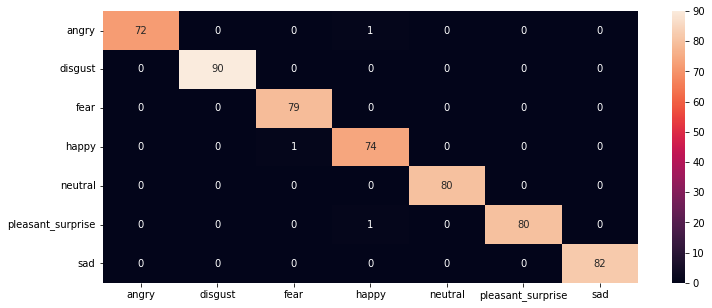

In [14]:
#confusion matrix
import seaborn as sns
sns.heatmap(matrix, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,annot=True,fmt="d");


Hence we see that on TESS dataset, this model achived a weighted average F1 score of 0.995